In [25]:
# Kaggle-adapted Setup and Imports (No pip needed - gym pre-installed)
# List input files for debugging
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Imports
import json
import random
import re
from collections import Counter, defaultdict
from typing import List, Dict, Tuple, Any

import gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from gym import spaces
from IPython.display import clear_output
from torch.cuda.amp import GradScaler, autocast

# Set seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

print("Kaggle Setup complete! GPU available:", torch.cuda.is_available())
print(f"Gym version: {gym.__version__} (pre-installed, no pip needed)")

/kaggle/input/datasetml/corpus.txt
/kaggle/input/datasetml/test.txt
Kaggle Setup complete! GPU available: True
Gym version: 0.25.2 (pre-installed, no pip needed)


In [26]:
import json
from math import inf

CONFIG = {
    "data": {
        "corpus_path": "/kaggle/input/datasetml/corpus.txt",
        "test_path":   "/kaggle/input/datasetml/test.txt",
        "train_split": 0.80,
        "val_split":   0.10,
        "length_buckets": [(1,4), (5,7), (8, float('inf'))],
        "hmm_smoothing_alpha": 1e-3,
        "ngram_weights": {"unigram":0.20, "bigram":0.20, "trigram":0.60}
    },

    # ---- NORMAL REWARDS (what you had before) ----
    "env": {
        "max_lives": 6,
        "rewards": {
            "correct":  1,
            "wrong":   -1,
            "repeat":  -2,
            "win":     50,
            "loss":    -20
        }
    },

    "dqn": {
    "lr":                3e-5,      # lower → smoother updates
    "gamma":             0.99,
    "batch_size":        256,       # larger batches
    "replay_capacity":   200_000,
    "min_replay_size":   5_000,
    "update_every":      2,         # learn twice as often
    "target_tau":        5e-4,      # slower target sync
    "per_alpha":         0.6,
    "per_beta_start":    0.4,
    "per_beta_end":      1.0,
    "per_beta_steps":    1_000_000,
    "epsilon_start":     1.0,
    "epsilon_end":       0.01,      # almost fully greedy at the end
    "epsilon_decay_steps": 250_000, # longer exploration
    "noisy_std":         0.3,       # less noise after decay
    "hidden_dims":       [512, 256, 128],   # bigger network
    "dropout":           0.1
},

    "training": {
        "parallel_envs": 16,
        "val_every":     50_000          # validation only at 50 k & 100 k
    },

    "eval": {
        "num_games": 2000
    }
}

with open("/kaggle/working/train_config.json", "w") as f:
    json.dump(CONFIG, f, indent=4)

print("CONFIG ready – run the next two cells.")

CONFIG ready – run the next two cells.


In [27]:
def clean_corpus(file_path: str) -> List[str]:
    """Read and clean corpus: lowercase, alphabetic only, remove duplicates."""
    with open(file_path, "r") as f:
        text = f.read().lower()
    words = re.findall(r'\b[a-z]+\b', text)
    words = list(set(words))  # Remove duplicates
    return words

# Load and clean corpus
corpus_words = clean_corpus(CONFIG["data"]["corpus_path"])
test_words = clean_corpus(CONFIG["data"]["test_path"])  # For final eval

# Stratified split by length
def stratified_split(words: List[str], train: float, val: float) -> Tuple[List[str], List[str], List[str]]:
    length_to_words = defaultdict(list)
    for w in words:
        length_to_words[len(w)].append(w)
    
    train_set, val_set, test_set = [], [], []
    for length, ws in length_to_words.items():
        np.random.shuffle(ws)
        n = len(ws)
        t = int(n * train)
        v = int(n * val)
        train_set.extend(ws[:t])
        val_set.extend(ws[t:t+v])
        test_set.extend(ws[t+v:])
    return train_set, val_set, test_set

train_words, val_words, _ = stratified_split(corpus_words, CONFIG["data"]["train_split"], CONFIG["data"]["val_split"])
print(f"Train: {len(train_words)}, Val: {len(val_words)}, Test words for eval: {len(test_words)}")

# Precompute word length distributions for sampling
train_length_dist = Counter(len(w) for w in train_words)

# Fixed: Global max_len for consistent obs_dim across all envs
global_max_len = max(len(w) for w in corpus_words)
print(f"Global max word length: {global_max_len}")
length_oh_dim = 30  # Fixed, covers up to 30 letters

Train: 39509, Val: 4928, Test words for eval: 2000
Global max word length: 24


In [28]:
from collections import defaultdict
from typing import List, Dict, Tuple
import numpy as np

class HMMOracle:
    def __init__(self, words: List[str], buckets: List[Tuple[int, int]], alpha: float, ngram_weights: Dict[str, float]):
        self.buckets = buckets
        self.alpha = alpha
        self.ngram_weights = ngram_weights
        self.stats = self._precompute_stats(words)

    def _get_bucket(self, length: int) -> Tuple[int, int]:
        for b in self.buckets:
            if b[0] <= length <= b[1]:
                return b
        raise ValueError(f"Length {length} not in buckets")

    def _precompute_stats(self, words: List[str]) -> Dict[Tuple[int, int], Dict]:
        stats = {}
        for bucket in self.buckets:
            bucket_words = [w for w in words if bucket[0] <= len(w) <= bucket[1]]
            if not bucket_words:
                continue
            
            # Fixed: Use actual max length in bucket (handles inf)
            max_len = max(len(w) for w in bucket_words)
            
            # Position-wise unigram freq: (pos, letter) -> count
            pos_freq = [defaultdict(int) for _ in range(max_len)]
            # Bigram: (prev_letter, letter) -> count
            bigram = defaultdict(lambda: defaultdict(int))
            # Trigram: (prev2, prev1, letter) -> count
            trigram = defaultdict(lambda: defaultdict(lambda: defaultdict(int)))
            
            total_letters = 0
            for w in bucket_words:
                padded = '^' + w + '$'  # Sentinels for n-grams
                for i in range(len(w)):
                    lett = w[i]
                    pos_freq[i][lett] += 1
                for i in range(1, len(padded)):
                    bigram[padded[i-1]][padded[i]] += 1
                for i in range(2, len(padded)):
                    trigram[padded[i-2]][padded[i-1]][padded[i]] += 1
                total_letters += len(w)
            
            # Normalize to probs with smoothing
            letters = 'abcdefghijklmnopqrstuvwxyz'
            unigram_prob = defaultdict(float)
            for lett in letters:
                unigram_prob[lett] = (sum(pos_freq[i][lett] for i in range(max_len)) + self.alpha) / (total_letters + self.alpha * 26)
            
            pos_prob = [{} for _ in range(max_len)]
            for i in range(max_len):
                total = sum(pos_freq[i].values()) + self.alpha * 26
                for lett in letters:
                    pos_prob[i][lett] = (pos_freq[i][lett] + self.alpha) / total
            
            bigram_prob = {}
            for prev in letters + '^':
                total = sum(bigram[prev].values()) + self.alpha * 26
                bigram_prob[prev] = {lett: (bigram[prev][lett] + self.alpha) / total for lett in letters}
            
            trigram_prob = {}
            for prev2 in letters + '^':
                trigram_prob[prev2] = {}
                for prev1 in letters + '^':
                    total = sum(trigram[prev2][prev1].values()) + self.alpha * 26
                    trigram_prob[prev2][prev1] = {lett: (trigram[prev2][prev1][lett] + self.alpha) / total for lett in letters}
            
            stats[bucket] = {
                "unigram": unigram_prob,
                "pos_prob": pos_prob,
                "bigram": bigram_prob,
                "trigram": trigram_prob,
                "max_len": max_len
            }
        return stats

    def oracle(self, masked_pattern: str, guessed_letters: set) -> np.ndarray:
        """Return prob vector (26) for each letter appearing in unknown positions."""
        length = len(masked_pattern)
        bucket = self._get_bucket(length)
        if bucket not in self.stats:
            return np.ones(26) / 26  # Uniform if no data
        
        s = self.stats[bucket]
        letters = 'abcdefghijklmnopqrstuvwxyz'
        idx = {lett: i for i, lett in enumerate(letters)}
        prob = np.zeros(26)
        
        unknown_pos = [i for i, c in enumerate(masked_pattern) if c == '_']
        if not unknown_pos:
            return prob  # All guessed
        
        # For each unknown position, compute P(letter | context) with backoff (robust weights)
        for pos in unknown_pos:
            # Determine available n-gram levels and weights
            trigram_weight = self.ngram_weights["trigram"]
            bigram_weight = self.ngram_weights["bigram"]
            unigram_weight = self.ngram_weights["unigram"]
            
            t_prob = None
            if pos >= 2 and masked_pattern[pos-2] != '_' and masked_pattern[pos-1] != '_':
                prev2, prev1 = masked_pattern[pos-2], masked_pattern[pos-1]
                t_prob = s["trigram"].get(prev2, {}).get(prev1, None)
            
            b_prob = None
            if pos >= 1 and masked_pattern[pos-1] != '_':
                prev = masked_pattern[pos-1]
                b_prob = s["bigram"].get(prev, None)
            
            u_prob = s["pos_prob"][pos]
            
            for lett in letters:
                if lett in guessed_letters:
                    continue
                p = 0.0
                if t_prob and lett in t_prob:
                    # Trigram primary, backoff to bigram/unigram
                    p += trigram_weight * t_prob[lett]
                    remaining_w = 1 - trigram_weight
                    if b_prob and lett in b_prob:
                        p += remaining_w * bigram_weight * b_prob[lett]
                        p += (1 - bigram_weight) * unigram_weight * u_prob.get(lett, 0.0)
                    else:
                        p += remaining_w * unigram_weight * u_prob.get(lett, 0.0)
                elif b_prob and lett in b_prob:
                    # Bigram primary, backoff to unigram
                    p += bigram_weight * b_prob[lett]
                    p += (1 - bigram_weight) * unigram_weight * u_prob.get(lett, 0.0)
                else:
                    # Unigram fallback
                    p = u_prob.get(lett, 0.0)
                prob[idx[lett]] += p
        
        prob /= max(1e-6, prob.sum())  # Normalize
        return prob

# Initialize HMM
hmm = HMMOracle(train_words, CONFIG["data"]["length_buckets"], CONFIG["data"]["hmm_smoothing_alpha"], CONFIG["data"]["ngram_weights"])

print("HMM Oracle initialized!")
print(f"Stats keys: {list(hmm.stats.keys())}")  # Debug: Should show buckets with data

HMM Oracle initialized!
Stats keys: [(1, 4), (5, 7), (8, inf)]


In [29]:
# Unit test for HMM
def test_hmm():
    masked = "_a__"
    guessed = set("eio")
    prob = hmm.oracle(masked, guessed)
    assert len(prob) == 26 and np.isclose(prob.sum(), 1.0)
    print("HMM test passed")

test_hmm()

HMM test passed


In [30]:
class HangmanEnv(gym.Env):
    def __init__(self, words: List[str], hmm: HMMOracle, max_lives: int = 6, rewards: Dict = None, global_max_len: int = None):
        self.words = words
        self.hmm = hmm
        self.max_lives = max_lives
        self.rewards = rewards or CONFIG["env"]["rewards"]
        self.letters = 'abcdefghijklmnopqrstuvwxyz'
        self.letter_to_idx = {l: i for i, l in enumerate(self.letters)}
        
        # Fixed: Use global_max_len for consistent obs_dim
        if global_max_len is None:
            global_max_len = max(len(w) for w in words)
        self.global_max_len = global_max_len
        length_oh_dim = 30  # Fixed
        self.obs_dim = global_max_len * 26 + 26 + 1 + 26 + length_oh_dim
        self.observation_space = spaces.Box(low=0, high=1, shape=(self.obs_dim,))
        self.action_space = spaces.Discrete(26)
        
        self.current_word = None
        self.masked = None
        self.guessed = None
        self.lives = None

    def reset(self):
        self.current_word = random.choice(self.words)
        self.masked = '_' * len(self.current_word)
        self.guessed = set()
        self.lives = self.max_lives
        return self._get_obs()

    def step(self, action: int):
        lett = self.letters[action]
        reward = 0
        done = False
        
        if lett in self.guessed:
            reward += self.rewards["repeat"]
        else:
            self.guessed.add(lett)
            if lett in self.current_word:
                # Update masked
                new_masked = list(self.masked)
                for i, c in enumerate(self.current_word):
                    if c == lett:
                        new_masked[i] = lett
                self.masked = ''.join(new_masked)
                reward += self.rewards["correct"]
            else:
                self.lives -= 1
                reward += self.rewards["wrong"]
        
        if '_' not in self.masked:
            done = True
            reward += self.rewards["win"]
        elif self.lives <= 0:
            done = True
            reward += self.rewards["loss"]
        
        return self._get_obs(), reward, done, {}

    def _get_obs(self) -> np.ndarray:
        word_len = len(self.current_word)
        # Fixed: Pattern padded to global_max_len
        pattern = np.zeros(self.global_max_len * 26)
        for i in range(word_len):  # Only fill up to actual length
            c = self.masked[i]
            if c != '_':
                pattern[i * 26 + self.letter_to_idx[c]] = 1.0
        
        # Guessed binary
        guessed = np.zeros(26)
        for l in self.guessed:
            guessed[self.letter_to_idx[l]] = 1.0
        
        # Lives normalized
        lives = np.array([self.lives / self.max_lives])
        
        # HMM prob
        hmm_prob = self.hmm.oracle(self.masked, self.guessed)
        
        # Length one-hot (fixed dim=30)
        len_oh = np.zeros(30)
        if word_len < 30:
            len_oh[word_len] = 1.0
        
        obs = np.concatenate([pattern, guessed, lives, hmm_prob, len_oh])
        return obs.astype(np.float32)

# Vectorized env for parallel training (pass global_max_len)
class VectorHangmanEnv:
    def __init__(self, num_envs: int, words: List[str], hmm: HMMOracle, global_max_len: int):
        self.num_envs = num_envs
        self.envs = [HangmanEnv(words, hmm, global_max_len=global_max_len) for _ in range(num_envs)]

    def reset(self):
        return np.stack([e.reset() for e in self.envs])

    def step(self, actions: np.ndarray):
        obs_list, rews, dones, infos = [], [], [], []
        for env_idx, a in enumerate(actions):
            o, r, d, info = self.envs[env_idx].step(a)
            obs_list.append(o)
            rews.append(r)
            dones.append(d)
            infos.append(info)
            if d:
                obs_list[-1] = self.envs[env_idx].reset()
        return np.stack(obs_list), np.array(rews), np.array(dones), infos

print("Environment classes defined!")

Environment classes defined!


In [31]:
# Unit test for env
def test_env():
    env = HangmanEnv(train_words[:10], hmm)
    obs = env.reset()
    assert obs.shape[0] == env.obs_dim
    _, r, d, _ = env.step(0)  # 'a'
    assert not d
    print("Env test passed")

test_env()

Env test passed


In [32]:
# Prioritized Experience Replay (unchanged from last)
class PERBuffer:
    def __init__(self, capacity: int, alpha: float):
        self.capacity = capacity
        self.alpha = alpha
        self.buffer = []  # List for dynamic growth
        self.priorities = []  # List for priorities
        self.pos = 0

    def add(self, experience: Tuple, error: float):
        priority = (error + 1e-5) ** self.alpha
        if len(self.buffer) < self.capacity:
            self.buffer.append(experience)
            self.priorities.append(priority)
        else:
            self.buffer[self.pos] = experience
            self.priorities[self.pos] = priority
            self.pos = (self.pos + 1) % self.capacity

    def sample(self, batch_size: int, beta: float):
        size = len(self.buffer)
        if size == 0:
            return [], np.array([]), np.array([])
        priors = np.array(self.priorities)
        probs = priors / priors.sum()
        indices = np.random.choice(size, batch_size, p=probs)
        samples = [self.buffer[i] for i in indices]
        weights = (size * probs[indices]) ** (-beta)
        weights /= weights.max()
        return samples, indices, weights.astype(np.float32)

    def update_priorities(self, indices: np.ndarray, errors: np.ndarray):
        for i, e in zip(indices, errors):
            self.priorities[i] = (np.abs(e) + 1e-5) ** self.alpha

# Noisy Linear Layer (unchanged)
class NoisyLinear(nn.Module):
    def __init__(self, in_features: int, out_features: int, std_init: float):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.std_init = std_init
        self.weight_mu = nn.Parameter(torch.empty(out_features, in_features))
        self.weight_sigma = nn.Parameter(torch.empty(out_features, in_features))
        self.register_buffer('weight_epsilon', torch.empty(out_features, in_features))
        self.bias_mu = nn.Parameter(torch.empty(out_features))
        self.bias_sigma = nn.Parameter(torch.empty(out_features))
        self.register_buffer('bias_epsilon', torch.empty(out_features))
        self.reset_parameters()
        self.sample_noise()

    def reset_parameters(self):
        mu_range = 1 / np.sqrt(self.in_features)
        self.weight_mu.data.uniform_(-mu_range, mu_range)
        self.weight_sigma.data.fill_(self.std_init / np.sqrt(self.in_features))
        self.bias_mu.data.uniform_(-mu_range, mu_range)
        self.bias_sigma.data.fill_(self.std_init / np.sqrt(self.out_features))

    def sample_noise(self):
        self.weight_epsilon.data.normal_()
        self.bias_epsilon.data.normal_()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if self.training:
            weight = self.weight_mu + self.weight_sigma * self.weight_epsilon
            bias = self.bias_mu + self.bias_sigma * self.bias_epsilon
        else:
            weight = self.weight_mu
            bias = self.bias_mu
        return F.linear(x, weight, bias)

# Dueling Double DQN with NoisyNet (fixed: to(device))
class DQN(nn.Module):
    def __init__(self, obs_dim: int, action_dim: int, hidden_dims: List[int], dropout: float, noisy_std: float, device: torch.device):
        super().__init__()
        layers = []
        prev_dim = obs_dim
        for h in hidden_dims:
            layers.append(nn.Linear(prev_dim, h))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            prev_dim = h
        self.feature_net = nn.Sequential(*layers)
        
        # Dueling streams
        self.value_stream = nn.Sequential(
            NoisyLinear(hidden_dims[-1], 128, noisy_std),
            nn.ReLU(),
            NoisyLinear(128, 1, noisy_std)
        )
        self.advantage_stream = nn.Sequential(
            NoisyLinear(hidden_dims[-1], 128, noisy_std),
            nn.ReLU(),
            NoisyLinear(128, action_dim, noisy_std)
        )
        self.to(device)  # Fixed: Move to GPU/CPU

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        features = self.feature_net(x)
        value = self.value_stream(features)
        advantage = self.advantage_stream(features)
        return value + advantage - advantage.mean(dim=1, keepdim=True)

print("Agent components defined!")

Agent components defined!


In [33]:
# -------------------------------------------------
# 2. train_dqn – unchanged except new AMP API
# -------------------------------------------------
def train_dqn(seed=SEED, total_steps=100_000, global_max_len=None, num_val_games=2000):
    torch.manual_seed(seed); np.random.seed(seed); random.seed(seed)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Device: {device}")

    # ---- env -------------------------------------------------
    env_words = train_words
    if global_max_len is None: global_max_len = max(len(w) for w in env_words)

    vec_env = VectorHangmanEnv(
        num_envs=CONFIG["training"]["parallel_envs"],
        words=env_words, hmm=hmm, global_max_len=global_max_len
    )

    # ---- nets ------------------------------------------------
    obs_dim = vec_env.envs[0].obs_dim
    q_net = DQN(obs_dim, 26, CONFIG["dqn"]["hidden_dims"],
                CONFIG["dqn"]["dropout"], CONFIG["dqn"]["noisy_std"], device)
    target_net = DQN(obs_dim, 26, CONFIG["dqn"]["hidden_dims"],
                     CONFIG["dqn"]["dropout"], CONFIG["dqn"]["noisy_std"], device)
    target_net.load_state_dict(q_net.state_dict())
    q_net.to(device); target_net.to(device)

    optimizer = torch.optim.AdamW(q_net.parameters(),
                                 lr=CONFIG["dqn"]["lr"], weight_decay=1e-6)

    scaler = torch.amp.GradScaler('cuda') if device.type == 'cuda' else None
    replay = PERBuffer(CONFIG["dqn"]["replay_capacity"], CONFIG["dqn"]["per_alpha"])

    steps = 0
    scores = []
    obs = vec_env.reset()

    print("Training started – progress every 1 k steps")
    while steps < total_steps:
        eps = max(CONFIG["dqn"]["epsilon_end"],
                  CONFIG["dqn"]["epsilon_start"] -
                  steps / CONFIG["dqn"]["epsilon_decay_steps"])

        # ---- act ------------------------------------------------
        actions = []
        for i in range(vec_env.num_envs):
            if random.random() < eps:
                actions.append(random.randint(0,25))
            else:
                with torch.no_grad():
                    q = q_net(torch.from_numpy(obs[i]).float().unsqueeze(0).to(device))
                    actions.append(q.argmax(1).item())
        actions = np.array(actions)

        # ---- step -----------------------------------------------
        next_obs, rewards, dones, _ = vec_env.step(actions)

        # ---- store ----------------------------------------------
        for o,a,r,no,d in zip(obs,actions,rewards,next_obs,dones):
            if d: next_q = 0
            else:
                with torch.no_grad():
                    next_q = target_net(torch.from_numpy(no).float().unsqueeze(0).to(device)).max(1)[0].item()
            target = r + CONFIG["dqn"]["gamma"] * next_q * (1-d)
            with torch.no_grad():
                cur_q = q_net(torch.from_numpy(o).float().unsqueeze(0).to(device))[0,a].item()
            replay.add((o,a,r,no,d), abs(target-cur_q))

        obs = next_obs
        steps += vec_env.num_envs

        # ---- progress -------------------------------------------
        if steps % 1_000 == 0:
            print(f"Step {steps:,} | Replay {len(replay.buffer):,}/{replay.capacity:,} | ε {eps:.3f}")

        # ---- learn ----------------------------------------------
        if steps % CONFIG["dqn"]["update_every"] == 0 and len(replay.buffer) >= CONFIG["dqn"]["min_replay_size"]:
            beta = CONFIG["dqn"]["per_beta_start"] + \
                   (CONFIG["dqn"]["per_beta_end"]-CONFIG["dqn"]["per_beta_start"]) * \
                   min(1, steps/CONFIG["dqn"]["per_beta_steps"])
            batch, idxs, w = replay.sample(CONFIG["dqn"]["batch_size"], beta)
            if not batch: continue
            b_o,b_a,b_r,b_no,b_d = map(np.stack, zip(*batch))

            with torch.amp.autocast('cuda') if device.type == 'cuda' else torch.no_grad():
                o_t  = torch.from_numpy(b_o).float().to(device)
                no_t = torch.from_numpy(b_no).float().to(device)
                q    = q_net(o_t).gather(1, torch.tensor(b_a,device=device).unsqueeze(1)).squeeze(1)
                next_a = q_net(no_t).argmax(1)
                next_q = target_net(no_t).gather(1, next_a.unsqueeze(1)).squeeze(1)
                tgt = torch.tensor(b_r,device=device) + CONFIG["dqn"]["gamma"]*next_q*(1-torch.tensor(b_d,device=device).float())
                loss = (F.mse_loss(q,tgt,reduction='none') *
                        torch.from_numpy(w).to(device)).mean()

            optimizer.zero_grad()
            if scaler:
                scaler.scale(loss).backward()
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(q_net.parameters(), 1.0)
                scaler.step(optimizer)
                scaler.update()
            else:
                loss.backward()
                torch.nn.utils.clip_grad_norm_(q_net.parameters(), 1.0)
                optimizer.step()

            replay.update_priorities(idxs, (q-tgt).abs().detach().cpu().numpy())

            # soft target update
            for t,s in zip(target_net.parameters(), q_net.parameters()):
                t.data.copy_(CONFIG["dqn"]["target_tau"]*s.data + (1-CONFIG["dqn"]["target_tau"])*t.data)

        # ---- validation -----------------------------------------
        if steps % CONFIG["training"]["val_every"] == 0:
            mets = evaluate_model(q_net, val_words, hmm,
                                  num_games=num_val_games,
                                  global_max_len=global_max_len,
                                  seed=SEED)
            scores.append((steps, mets['score']))
            clear_output(wait=True)
            plt.figure(figsize=(9,4))
            plt.plot(*zip(*scores), 'o-', color='purple')
            plt.title(f"Live Score @ {steps:,} steps")
            plt.xlabel("Steps"); plt.ylabel(f"Score ({num_val_games} games)")
            plt.grid(True); plt.show()

            print(f"Validation @ {steps:,} steps")
            print("+-------------------+----------+")
            print("| Metric            | Value    |")
            print("+-------------------+----------+")
            print(f"| Total Games       | {mets['total_games']:>8} |")
            print(f"| Wins              | {mets['wins']:>8} |")
            print(f"| Success Rate      | {mets['success_rate']*100:>6.1f}% |")
            print(f"| Total Wrong       | {mets['total_wrong']:>8} |")
            print(f"| Avg Wrong         | {mets['avg_wrong']:>6.1f} |")
            print(f"| Total Repeat      | {mets['total_repeat']:>8} |")
            print(f"| Avg Repeat        | {mets['avg_repeat']:>6.1f} |")
            print(f"| Score             | {mets['score']:>8.1f} |")
            print("+-------------------+----------+")

    return q_net, scores

print("train_dqn + evaluate_model ready – run the demo cell.")

train_dqn + evaluate_model ready – run the demo cell.


In [34]:
def identify_hard_words(words: List[str], model: nn.Module, hmm: HMMOracle, threshold: int = 3):
    """Simulate games on val, collect words with >= threshold wrong guesses."""
    hard = set()
    env = HangmanEnv(words, hmm)
    for w in words[:50]:  # Limit for speed
        env.current_word = w
        env.masked = '_' * len(w)
        env.guessed = set()
        env.lives = 6
        wrong = 0
        done = False
        while not done:
            obs = env._get_obs()
            act = model(torch.from_numpy(obs).float().unsqueeze(0)).argmax(-1).item()
            lett = env.letters[act]
            if lett in env.guessed:
                break  # Repeat
            env.guessed.add(lett)
            if lett not in env.current_word:
                wrong += 1
                env.lives -= 1
            else:
                new_masked = list(env.masked)
                for i, c in enumerate(env.current_word):
                    if c == lett:
                        new_masked[i] = lett
                env.masked = ''.join(new_masked)
            done = env.lives <= 0 or '_' not in env.masked
        if wrong >= threshold:
            hard.add(w)
    return list(hard)

In [35]:
import random, numpy as np, torch, torch.nn as nn, torch.nn.functional as F
import matplotlib.pyplot as plt
from IPython.display import clear_output

# -------------------------------------------------
# 1. evaluate_model – correct masking + early stop
# -------------------------------------------------
def evaluate_model(model, words, hmm, num_games, global_max_len, seed=SEED):
    np.random.seed(seed); random.seed(seed)
    is_ens = isinstance(model, list)
    device = next(model.parameters()).device if not is_ens else next(model[0].parameters()).device
    env = HangmanEnv(words, hmm, global_max_len=global_max_len)

    total_games = wins = total_wrong = total_repeat = 0
    games = min(num_games, len(words))
    eval_words = np.random.choice(words, games, replace=False).tolist()

    for word in eval_words:
        # manual reset
        env.current_word = word
        env.masked = '_' * len(word)
        env.guessed = set()
        env.lives = env.max_lives
        obs = env._get_obs()

        done = False
        wrong = repeat = 0
        step = 0
        MAX_STEPS = 50

        while not done and step < MAX_STEPS:
            # ---- Q-values + mask ----
            obs_t = torch.from_numpy(obs).float().unsqueeze(0).to(device)
            with torch.no_grad():
                if is_ens:
                    q = torch.stack([m(obs_t) for m in model]).mean(0)
                else:
                    q = model(obs_t)

                mask = torch.ones(26, device=device)
                for let in env.guessed:
                    mask[env.letter_to_idx[let]] = float('-inf')
                q = q + mask.unsqueeze(0)
                act = q.argmax(1).item()

            obs, r, done, _ = env.step(act)
            step += 1

            if r == env.rewards["repeat"]:   repeat += 1
            if r == env.rewards["wrong"]:    wrong  += 1

            # *** EARLY STOP when lives are gone ***
            if env.lives <= 0:
                done = True

        wins += ('_' not in env.masked)
        total_wrong  += wrong
        total_repeat += repeat
        total_games  += 1

    success = wins / total_games
    score   = success * 2000 - total_wrong * 5 - total_repeat * 2
    return {
        'score': score, 'total_games': total_games, 'wins': wins,
        'success_rate': success, 'total_wrong': total_wrong,
        'avg_wrong': total_wrong/total_games,
        'total_repeat': total_repeat, 'avg_repeat': total_repeat/total_games
    }

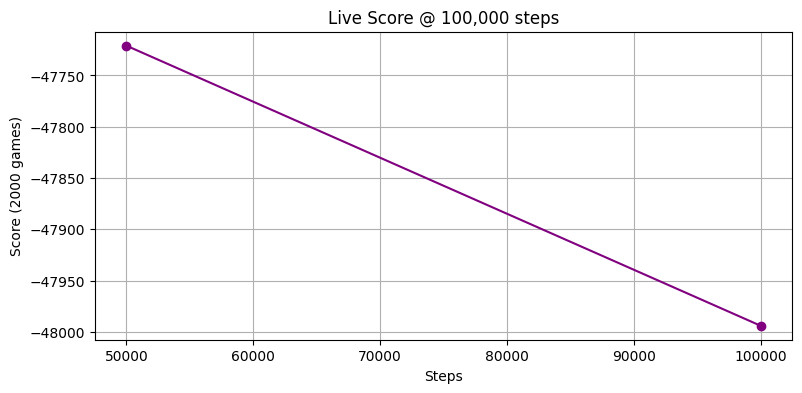

Validation @ 100,000 steps
+-------------------+----------+
| Metric            | Value    |
+-------------------+----------+
| Total Games       |     2000 |
| Wins              |      341 |
| Success Rate      |   17.1% |
| Total Wrong       |     9667 |
| Avg Wrong         |    4.8 |
| Total Repeat      |        0 |
| Avg Repeat        |    0.0 |
| Score             | -47994.0 |
+-------------------+----------+


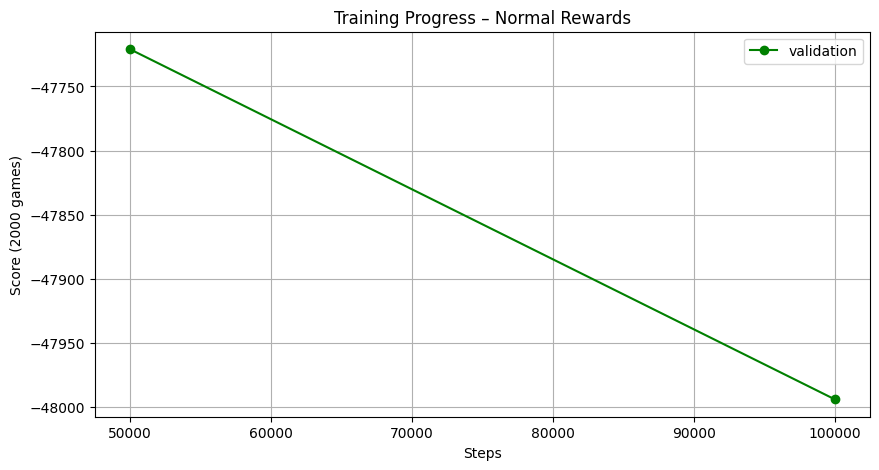


FINAL RESULT
+-------------------+----------+
| Metric            | Value    |
+-------------------+----------+
| Total Games       |     2000 |
| Wins              |      338 |
| Success Rate      |   16.9% |
| Total Wrong       |     9659 |
| Avg Wrong         |    4.8 |
| Total Repeat      |        0 |
| Avg Repeat        |    0.0 |
| Score             | -47957.0 |
+-------------------+----------+


In [36]:
print("=== STARTING TRAINING (100 k steps, 2000-game eval) ===")
demo_net, demo_scores = train_dqn(
    total_steps=100_000,
    global_max_len=global_max_len,
    num_val_games=2000
)

final_metrics = evaluate_model(
    demo_net, val_words, hmm,
    num_games=2000, global_max_len=global_max_len, seed=SEED
)

# ---- plot ------------------------------------------------
if demo_scores:
    steps, vals = zip(*demo_scores)
    plt.figure(figsize=(10,5))
    plt.plot(steps, vals, 'o-', color='green', label='validation')
    plt.title("Training Progress – Normal Rewards")
    plt.xlabel("Steps"); plt.ylabel("Score (2000 games)")
    plt.grid(True); plt.legend(); plt.show()

# ---- final table -----------------------------------------
print("\nFINAL RESULT")
print("+-------------------+----------+")
print("| Metric            | Value    |")
print("+-------------------+----------+")
print(f"| Total Games       | {final_metrics['total_games']:>8} |")
print(f"| Wins              | {final_metrics['wins']:>8} |")
print(f"| Success Rate      | {final_metrics['success_rate']*100:>6.1f}% |")
print(f"| Total Wrong       | {final_metrics['total_wrong']:>8} |")
print(f"| Avg Wrong         | {final_metrics['avg_wrong']:>6.1f} |")
print(f"| Total Repeat      | {final_metrics['total_repeat']:>8} |")
print(f"| Avg Repeat        | {final_metrics['avg_repeat']:>6.1f} |")
print(f"| Score             | {final_metrics['score']:>8.1f} |")
print("+-------------------+----------+")